In [2]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

from model import ode_y, ode_y_parallel
from simulation import simulation
from utilities import find_nearest_value, compute_derivatives
from solver import false_transient_one_iteration_python
from numba import njit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
# Intensity parameter
epsilon = 1.

r1 = -54.1669
r0 = -1.0957 / epsilon

# Robustness parameters
ξ_w = 100000.
ξ_p = 5.
ξ_a = 1./100

damage_setting={'γ_2p': np.array([0, .0197*2, .3853*2]),
                'πd_o': np.array([1./3, 1./3, 1./3])}

# Model parameters
η = .032
δ = .01

θ = pd.read_csv('../data/model144.csv', header=None).to_numpy()[:, 0]/1000.
πc_o = np.ones_like(θ)/len(θ)
σ_y = 1.2*np.mean(θ)

γ_1 = 1.7675/10000
γ_2 = .0022*2
γ_2p = damage_setting['γ_2p']
πd_o = damage_setting['πd_o']

y_bar_upper = 1.9
y_bar_lower = 1.7

# Grid setting
ϵ = 1.
y_step = .02
y_grid_long = np.arange(0., y_bar_upper*2+y_step, y_step)
y_grid_short = np.arange(0., y_bar_upper+y_step, y_step)
y_bar_lower_loc = find_nearest_value(y_grid_short, y_bar_lower)
y_bar_upper_loc = find_nearest_value(y_grid_long, y_bar_upper)
y_grid_tilde = y_grid_short[y_bar_lower_loc: y_bar_upper_loc]

In [4]:
model_paras_low = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[0], y_bar_upper)
model_low = ode_y(y_grid_long, model_paras_low, None, ϵ, 1e-8, 5000, False)
model_paras_high = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[1], y_bar_upper)
model_high = ode_y(y_grid_long, model_paras_high, None, ϵ, 1e-8, 5000, False)
model_paras_extreme = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_a, γ_1, γ_2, γ_2p[2], y_bar_upper)
model_extreme = ode_y(y_grid_long, model_paras_extreme, None, ϵ, 1e-8, 5000, False)

Converged. Total iteration 5000: LHS Error: 5.668421636073617e-05; RHS Error 0.0001040060840689222
Converged. Total iteration 1508: LHS Error: 9.957308533259379e-09; RHS Error 0.00045677485837929827
Converged. Total iteration 1621: LHS Error: 9.972726644491559e-09; RHS Error 0.0020590635522112835


In [5]:
# Prepare ϕ_m
ϕ_m = np.zeros((3, len(y_grid_short)))
ϕ_m[0] = model_low['v0'][:y_bar_upper_loc+1]
ϕ_m[1] = model_high['v0'][:y_bar_upper_loc+1]
ϕ_m[2] = model_extreme['v0'][:y_bar_upper_loc+1]
v_guess = np.average(ϕ_m, weights=πd_o, axis=0)

In [6]:
def ode_y_jump_intensity_approach(y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8,
                                     max_iter=10_000, print_all=True):
    η, δ, θ, πc_o, σ_y, ξ_1m, ξ_2m, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_i, πd_o, r0, r1, epsilon = model_paras
    Δ_y = y_grid[1] - y_grid[0]

    if v0 is None:
        v0 = -η*(y_grid+y_grid**2)

    d_Λ = γ_1 + γ_2*y_grid
    dd_Λ = γ_2

    πd = np.ones((len(πd_o), len(y_grid)))
    for i in range(πd.shape[0]):
        πd[i] = πd_o[i]
    πd_o = πd

    πc = np.ones((len(πc_o), len(y_grid)))
    θ_reshape = np.ones_like(πc)
    for i in range(πc.shape[0]):
        πc[i] = πc_o[i]
        θ_reshape[i] = θ[i]
    πc_o = πc.copy()
    θ = θ_reshape

    ς = .5
    intensity = 1. / (np.sqrt(2) * ς) * np.exp(- (y_bar_upper - y_grid) ** 2 / (2 * ς ** 2))

    e_tilde = 0.
    
    count = 0
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        e_tilde_old = e_tilde

        v0_dy = compute_derivatives(v0, 1, Δ_y, central_diff=False)
        v0_dyy = compute_derivatives(v0, 2, Δ_y)

        G = v0_dy + (η-1)/δ*d_Λ

        if σ_y == 0:
            e_tilde = -η/(G*np.sum(πc*θ, axis=0))
        else:
            temp = σ_y**2*(v0_dyy+(η-1.)/δ*dd_Λ-G**2/ξ_1m)
            root = np.sum(πc*θ, axis=0)**2*G**2 - 4*η*temp
            root[root<0] = 0.
            e_tilde = (-G*np.sum(πc*θ, axis=0) - np.sqrt(root)) / (2*temp)

        e_tilde[e_tilde<=0] = 1e-16
        e_tilde = e_tilde *.5 + e_tilde_old*.5

        log_πc_ratio = -G*e_tilde*θ/ξ_a
        πc_ratio = log_πc_ratio - np.max(log_πc_ratio, axis=0)
        πc = np.exp(πc_ratio) * πc_o
        πc = πc/np.sum(πc, axis=0)
        πc[πc<=0] = 1e-16        
        c_entropy = np.sum(πc*(np.log(πc)-np.log(πc_o)), axis=0)

        g = np.exp(1./ξ_2m*(v0-ϕ_i))

        A = np.ones_like(y_grid)*(-δ)
        B = e_tilde * np.sum(πc*θ, axis=0)
        C = .5 * σ_y**2 * e_tilde**2
        D = η*np.log(e_tilde) - C*G**2/ξ_1m + (η-1)/δ*d_Λ*e_tilde*np.sum(πc*θ, axis=0)\
            + .5*(η-1)/δ*dd_Λ*σ_y**2*e_tilde**2 + ξ_a*c_entropy\
            - ξ_2m * intensity * (np.sum(πd_o * np.exp(-1./ξ_2m*ϕ_i), axis=0) - np.exp(-1./ξ_2m * v0)) \
                / np.exp(-1./ξ_2m * v0)

        v0 = false_transient_one_iteration_python(A, B, C, D, v0, ε, Δ_y, (0, 0), (False, False))

        rhs_error = A*v0 + B*v0_dy + C*v0_dyy + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error
        count += 1
        if print_all:
            print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))

    h = -(v0_dy+(η-1)/δ*d_Λ)*e_tilde*σ_y/ξ_1m
    πd = g / np.sum(πd_o * g, axis=0) * πd_o
    
    
    print("Converged. Total iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))     
    res = {'v0': v0,
           'v0_dy': v0_dy,
           'v0_dyy': v0_dyy,
           'e_tilde': e_tilde,
           'y_grid': y_grid,
           'intensity': intensity,
           'πc': πc,
           'πd': πd,
           'g': g,
           'h': h,
           'θ': θ[:, 0],
           'σ_y': σ_y}
    return res

In [7]:
model_paras = (η, δ, θ, πc_o, σ_y, ξ_w, ξ_p, ξ_a, γ_1, γ_2, y_bar_lower, y_bar_upper, ϕ_m, πd_o, r0, r1, epsilon)
model_res = ode_y_jump_intensity_approach(y_grid_short, model_paras=model_paras, v0=v_guess, ϵ=1,
                                          tol=1e-8, max_iter=500, print_all=True)

Iteration 1: LHS Error: 1.2227288493435207; RHS Error 1.2102297587878563
Iteration 2: LHS Error: 0.5742722560931781; RHS Error 0.5673480120697509
Iteration 3: LHS Error: 0.21459006740625752; RHS Error 0.21187280610732706
Iteration 4: LHS Error: 0.09117035782297261; RHS Error 0.09001460782158432
Iteration 5: LHS Error: 0.03713984223622124; RHS Error 0.036547195047769515
Iteration 6: LHS Error: 0.015422115270384174; RHS Error 0.015968108299682114
Iteration 7: LHS Error: 0.00841359837174016; RHS Error 0.008189634897989163
Iteration 8: LHS Error: 0.007327087810012234; RHS Error 0.007114700703146022
Iteration 9: LHS Error: 0.006531284272885074; RHS Error 0.006327881640878143
Iteration 10: LHS Error: 0.005924566619699867; RHS Error 0.00572834646818042
Iteration 11: LHS Error: 0.005447384679602596; RHS Error 0.00525891439590663
Iteration 12: LHS Error: 0.00506595014784228; RHS Error 0.004886764433839917
Iteration 13: LHS Error: 0.004754672918752867; RHS Error 0.004577917799094167
Iteration 14

In [8]:
et, yt, ht, gt = simulation(model_res['y_grid'], model_res['e_tilde'], model_res['h'], model_res['g'],
                            θ=np.mean(model_res['θ']), y_start=1.1, T=100)

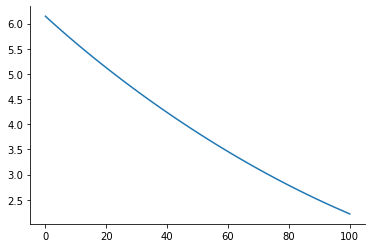

In [9]:
plt.plot(et)

In [11]:
np.save('ems_previous_1p1_1p9.npy', et)